In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import thinkstats2, thinkplot
from sklearn.linear_model import Ridge, LogisticRegression, Lasso, RidgeClassifier, ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, accuracy_score

### Data cleaning

In [20]:
x = pd.read_csv('../Data/train_values.csv')
y = pd.read_csv('../Data/train_labels.csv')
x = x.drop('patient_id', axis=1)
y = y['heart_disease_present']
categorical_vars= ['thal', 'chest_pain_type'] # list of categorical variables

Standardize the data by subtracting mean and dividing standard deviation.

In [21]:
for col in x.columns:
    if col not in categorical_vars:
        mean = x[col].mean()
        std = x[col].std()
        x[col] = (x[col] - mean)/std

One hot encoding the categorical data and drop the first column to prevent linear dependence/collinearity.

In [22]:
x = pd.get_dummies(x, columns=categorical_vars, drop_first=True)
x.head()

,slope_of_peak_exercise_st_segment,resting_blood_pressure,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,thal_normal,thal_reversible_defect,chest_pain_type_2,chest_pain_type_3,chest_pain_type_4
0,-0.888762,-0.194652,-0.716404,-0.437019,0.951196,1.115158,-0.900694,0.670152,-1.051032,0.929891,-0.678852,1,0,1,0,0
1,0.727169,-1.252825,-0.716404,-0.437019,-1.051322,-0.667915,0.526148,-1.483908,-0.086892,0.386007,-0.678852,1,0,0,1,0
2,-0.888762,-0.371014,2.378462,-0.437019,0.951196,1.039283,-0.900694,0.670152,2.377024,0.567302,1.464891,1,0,0,0,1
3,-0.888762,1.216246,-0.716404,-0.437019,-1.051322,-0.497195,-0.900694,0.670152,-1.586666,1.428452,-0.678852,0,1,0,0,1
4,2.343100,2.744719,-0.716404,-0.437019,0.951196,0.394342,2.844768,0.670152,0.448742,-0.203201,-0.678852,0,1,0,0,0


### Comparing different models

First, we define our helper function that run 1000 simulations:
- Shuffles the data
- Splits the data into training and test sets (80:20)
- Trains the model and computes accuracy on the test set
- Adds the accuracy to the list

In [23]:
def printAndPlotPmf(accs):
    print("Mean Accuracy:", round(np.mean(accs), 2), "| Median Accuracy:", round(np.median(accs), 2), "| Max Accuracy:", round(np.max(accs), 2))
    pmf = thinkstats2.Pmf(accs)
    thinkplot.Hist(pmf)
    
def GetAccuracyDist(model=None, inter=1000):
    if model is None:
        raise TypeError
        
    accs = []
    for _ in range(inter):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)
        model.fit(x_train, y_train)
        y_test_pred = model.predict(x_test)
        acc = accuracy_score(np.round(y_test_pred), y_test)
        accs.append(acc)
    
    printAndPlotPmf(accs)
    return np.asarray(accs)

In [24]:
accs_df = pd.DataFrame()

#### [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

Mean Accuracy: 0.82 | Median Accuracy: 0.83 | Max Accuracy: 0.97


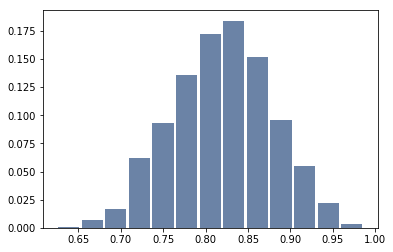

In [25]:
accs = GetAccuracyDist(LogisticRegression())
accs_df['Logistic'] = accs

#### [k-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) 

"The principle behind nearest neighbor methods is to find a predefined number of training samples closest in distance to the new point, and predict the label from these."

Mean Accuracy: 0.8 | Median Accuracy: 0.81 | Max Accuracy: 0.97


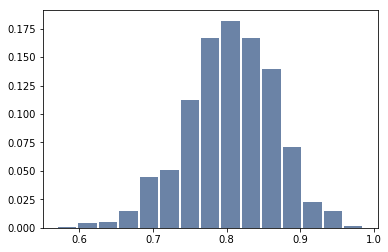

In [26]:
accs = GetAccuracyDist(KNeighborsClassifier(n_neighbors=3))
accs_df['KNN'] = accs

#### [RidgeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html)

Classifier using Ridge regression.

Mean Accuracy: 0.82 | Median Accuracy: 0.83 | Max Accuracy: 1.0


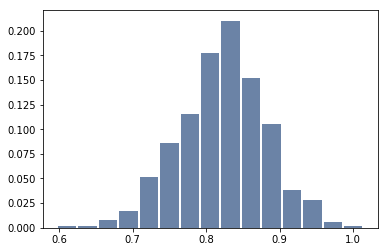

In [27]:
accs = GetAccuracyDist(RidgeClassifier(normalize=True))
accs_df['Ridge'] = accs

#### [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Mean Accuracy: 0.78 | Median Accuracy: 0.78 | Max Accuracy: 0.94


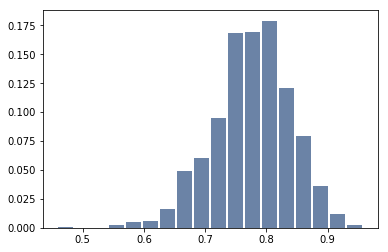

In [28]:
accs = GetAccuracyDist(RandomForestClassifier())
accs_df['Forest'] = accs

#### [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

Mean Accuracy: 0.56 | Median Accuracy: 0.56 | Max Accuracy: 0.78


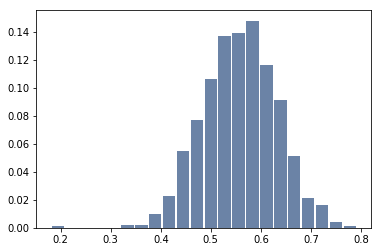

In [29]:
accs = GetAccuracyDist(Lasso())
accs_df['Lasso'] = accs

#### [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)

Mean Accuracy: 0.55 | Median Accuracy: 0.56 | Max Accuracy: 0.75


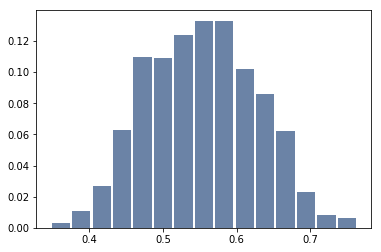

In [30]:
accs = GetAccuracyDist(ElasticNet())
accs_df['ElasticNet'] = accs

#### [Neural Net](https://keras.io/layers/core/)

Using Keras as a high-level API for TensorFlow, we experiment with a simple neural network with 4 layers:
- First hidden layer using `relu` activation function consists of 17 neurons
- Second hidden layer using `relu` activation function consists of 21 neurons
- Third hidden layer using `relu` activation function consists of 25 neurons
- Final output layer using `softmax` activation function layer consists of 2 neurons to classify the two classes (heart disease present or not)

We also apply **L2 regularization (Ridge)** to each layer and use **early stopping** to address the over-fitting problem. We use `categorical_crossentropy` loss as a general loss function for any classification problems. For the optimizer, because our training data has only a dozen of features and 144 samples, Adam optimizer tends to over-fit the model more quickly than Stochastic Gradient Descent (SGD), we choose SGD with the tuned learning rate of 0.008.

In [31]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers, regularizers

In [32]:
def plotAccuracyAndLoss(history):
    fig, ax = plt.subplots(1, 2, figsize=(14,4))
    #  "Accuracy"
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set(xlabel='Epoch', ylabel='Accuracy')
    ax[0].set_title('Model Accuracy')
    ax[0].legend(['train', 'validation'], loc='upper left')
    # "Loss"
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set(xlabel='Epoch', ylabel='Loss')
    ax[1].set_title('Model Loss')
    ax[1].legend(['train', 'validation'], loc='upper left')
    plt.show()

In [33]:
early_stopping_monitor = EarlyStopping(patience=2)
optim = optimizers.SGD(lr=0.008)

min_loss = np.inf
best_history = None
accs = []
for _ in range(50):
    model = Sequential()
    model.add(Dense(17, activation='relu', input_shape=(x.shape[1],), use_bias=True, kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(21, activation='relu', use_bias=True, kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(25, activation='relu', use_bias=True, kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(2, activation='softmax', use_bias=True, kernel_regularizer=regularizers.l2(0.0001)))
    model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x, to_categorical(y), shuffle=True, validation_split=0.20, epochs=500, callbacks = [early_stopping_monitor], verbose=False)
    accs.append(history.history['val_accuracy'][-1])
    if min_loss > history.history['val_loss'][-1]:
        min_loss = history.history['val_loss'][-1]
        best_history = history

The below figures show the accuracy and loss curves for training and validation sets of the best model (accuracy = 81%).

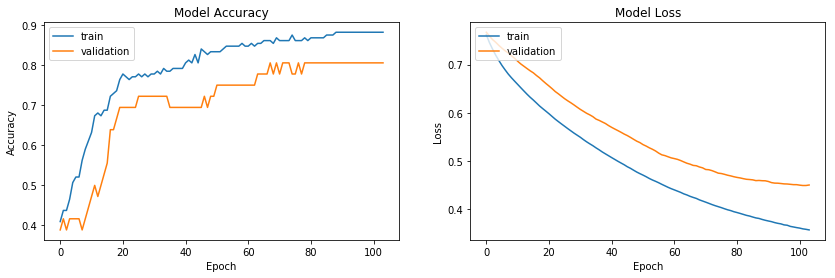

In [34]:
plotAccuracyAndLoss(best_history)

The distribution of accuracy is shown below

Mean Accuracy: 0.67 | Median Accuracy: 0.68 | Max Accuracy: 0.83


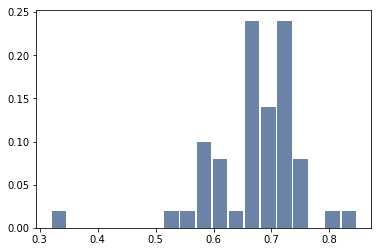

In [35]:
accs_df['NeuralNet'] = np.nan
accs_df['NeuralNet'][0:len(accs)] = accs
printAndPlotPmf(accs)

The mean accuracy of the neural network is fairly low compared to other models, and the max accuracy is about the same as the mean accuracy of Logistic Regression, KNN and Ridge. The neural network model does not work as well as other simpler models even thought it takes more time to tune and train the neural net.

#### Boxplot

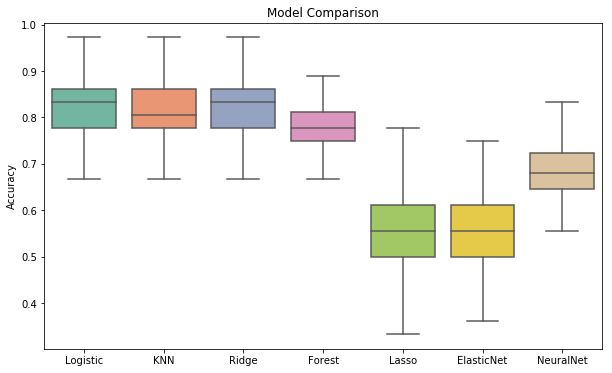

In [36]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.boxplot(data=accs_df, palette="Set2", showfliers=False)
_ = ax.set(ylabel="Accuracy", title="Model Comparison")